## Engine sound analysis

In [1]:
import os
import glob
import librosa
import numpy as np
import matplotlib.pyplot as plt

Firstly, let's extract signatures from datasets of vehicles and fighters by double fourier trasform.

In [13]:
FFTSIZE = 2**9
DUAL_FFTSIZE = 2**10
MAX_FREQ_BINS = 300

HOP_LENGTH_RATIO = 4
hop_length_1 = int(FFTSIZE / HOP_LENGTH_RATIO)
hop_length_2 = int(DUAL_FFTSIZE / HOP_LENGTH_RATIO)

INPUT_DATA_DIR1 = r"C:\Users\duina\repo\DA\engine_sound\vehicle_engine_audio_data"
INPUT_DATA_DIR2 = r"C:\Users\duina\repo\DA\engine_sound\fighter_engine_audio_data"
OUTPUT_SIGNATURE_DIR = r"C:\Users\duina\repo\DA\engine_sound\signatures"
OUTPUT_PLOT_DIR = r"C:\Users\duina\repo\DA\engine_sound\plots"
GENERATE_PLOTS = False

os.makedirs(OUTPUT_SIGNATURE_DIR, exist_ok=True)
if GENERATE_PLOTS:
    os.makedirs(OUTPUT_PLOT_DIR, exist_ok=True)

audio_files1 = glob.glob(os.path.join(INPUT_DATA_DIR1, '*.wav'))
audio_files2 = glob.glob(os.path.join(INPUT_DATA_DIR2, '*.wav'))
audio_files = audio_files1 + audio_files2
audio_files_labels = ['v']*len(audio_files1) + ['f']*len(audio_files2)
len(audio_files)

95

In [14]:
for i, file_path in enumerate(audio_files):
    base_filename = os.path.splitext(os.path.basename(file_path))[0]

    y, sr = librosa.load(file_path, sr=None)
    # first STFT
    S = librosa.stft(y, n_fft=FFTSIZE, hop_length=hop_length_1)

    if S.shape[0] < MAX_FREQ_BINS:
        current_max_freq_bins = S.shape[0]
    else:
        current_max_freq_bins = MAX_FREQ_BINS
    S = S[0:current_max_freq_bins, :]

    # second STFT
    all_Sx_magnitudes = []
    max_ndiagrams = 0
    nrows_modulation = int(DUAL_FFTSIZE / 2) + 1

    for freq_bin_idx in range(S.shape[0]):
        x = np.absolute(S[freq_bin_idx, :])

        if len(x) < DUAL_FFTSIZE:
            pad_width = DUAL_FFTSIZE - len(x)
            x = np.pad(x, (0, pad_width), mode='constant')

        Sx = librosa.stft(x, n_fft=DUAL_FFTSIZE, hop_length=hop_length_2)
        Sx_mag = np.absolute(Sx)
        all_Sx_magnitudes.append(Sx_mag)

        if Sx_mag.shape[1] > max_ndiagrams:
            max_ndiagrams = Sx_mag.shape[1]

    ncols_original_freq = S.shape[0]
    Signature_power = np.zeros((ncols_original_freq, nrows_modulation, max_ndiagrams))

    for freq_bin_idx in range(ncols_original_freq):
        Sx_mag = all_Sx_magnitudes[freq_bin_idx]
        current_ndiagrams = Sx_mag.shape[1]
        Signature_power[freq_bin_idx, :, :current_ndiagrams] = Sx_mag

    output_signature_path = os.path.join(OUTPUT_SIGNATURE_DIR, f"{i}_signature.npy")
    np.save(output_signature_path, Signature_power)

    if GENERATE_PLOTS:
        for d in range(max_ndiagrams):
            signature_slice = Signature_power[:, :, d]
            signature_slice_db = librosa.amplitude_to_db(np.abs(signature_slice), ref=np.max, top_db=80.0)

            plt.figure(figsize=(10, 6))
            librosa.display.specshow(signature_slice_db, sr=sr, hop_length=hop_length_1, x_axis='linear', y_axis='linear')
            plt.colorbar(format='%+2.0f dB')

            plt.xlabel(f"Modulation Frequency (Bin Index, DUAL_FFTSIZE={DUAL_FFTSIZE})")
            plt.ylabel(f"Original Frequency (Bin Index, FFTSIZE={FFTSIZE})")

            plt.title(f'Double FFT Signature Power (Modulation Frame {d})\n{base_filename}')
            plot_filename = os.path.join(OUTPUT_PLOT_DIR, f"{base_filename}_dualfft_power-{d}.png")
            plt.savefig(plot_filename)
            plt.close()


So, now we have signatures (saved in folder) and label for each.

In [18]:
signature_files = sorted(glob.glob(os.path.join(OUTPUT_SIGNATURE_DIR, '*.npy')))
X = np.array([np.load(f_path).flatten() for f_path in signature_files])
X_labels = audio_files_labels
n_samples, n_features = X.shape
X[0], X_labels[0]

(array([3.47531013e+01, 5.85441933e+01, 6.26686745e+01, ...,
        1.05226953e-02, 4.09989897e-03, 9.55084246e-03]),
 'v')

Let's analyze this signatures. We expect to see two clearly distinct clusters (two types of engines: vehicle and fighter).

In [19]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

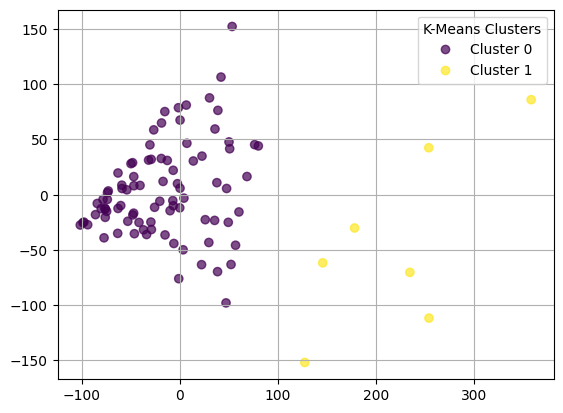

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, init="k-means++", n_init=20)
kmeans.fit(X_scaled)
kmeans_clusters = kmeans.labels_

plt.figure()
scatter_kmeans = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_clusters, cmap='viridis', alpha=0.7)
plt.legend(handles=scatter_kmeans.legend_elements()[0], labels=[f'Cluster {i}' for i in range(2)], title="K-Means Clusters")
plt.grid(True)

Now let's try to classify this sounds using simple Perceptron.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron 
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(X_scaled, X_labels, test_size=0.2, shuffle=True, random_state=666)

classifier = Perceptron(random_state=666)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"\nClassifier Accuracy on Test Set: {accuracy:.4f}")
print("\nClassification Report:\n")
print(report)


Classifier Accuracy on Test Set: 0.8947

Classification Report:

              precision    recall  f1-score   support

           f       1.00      0.60      0.75         5
           v       0.88      1.00      0.93        14

    accuracy                           0.89        19
   macro avg       0.94      0.80      0.84        19
weighted avg       0.91      0.89      0.89        19



Such a good result with such a simple model!

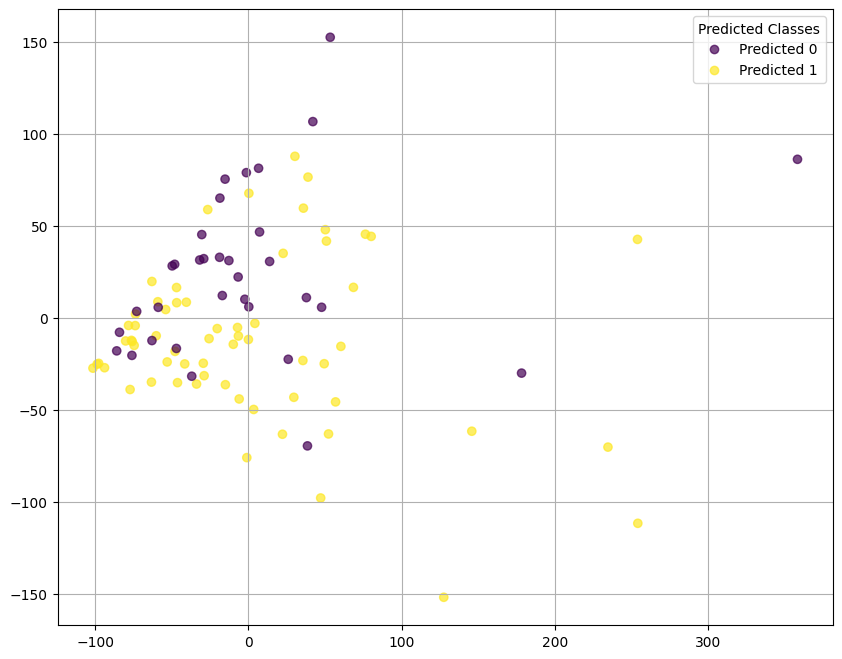

In [57]:
y_pred_all = classifier.predict(X_scaled)
y_pred_all = [1 if char == 'v' else 0 for char in y_pred_all if char in ('v', 'f')]

plt.figure(figsize=(10, 8))
scatter_pred = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_all, cmap='viridis', alpha=0.7)
unique_predicted_labels = np.unique(y_pred_all)
handles, labels_from_elements = scatter_pred.legend_elements()
legend_labels = [f'Predicted {i}' for i in unique_predicted_labels]
plt.legend(handles=handles, labels=legend_labels, title="Predicted Classes")
plt.grid(True)
plt.show()

So, as we see, it was bad idea to perform clustering on X_pca data.